# Генератор синуса

## Импорты и функции

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded


# генератор синуса на основе алгоритма Гёрцеля
def Goertzel_sin_oscillator(freq, sample_rate):
    omega = 2 * math.pi * freq / sample_rate
    coef = 2 * math.cos(omega)
    y_prev = 0.0
    y_prev_prev = math.sin(-omega)

    def next_sample():
        nonlocal y_prev, y_prev_prev
        y_current = coef * y_prev - y_prev_prev
        y_prev_prev, y_prev = y_prev, y_current
        return y_current

    return next_sample


# интерполяция кубическим сплайном
def Cubic_spline_interpoly(x_data, y_data, x):
    x_data = np.asarray(x_data)
    y_data = np.asarray(y_data)
    x = np.asarray(x)
    n = len(x_data) - 1

    h = np.diff(x_data)
    delta = np.diff(y_data) / h

    A = np.zeros((3, n - 1))
    A[1, 0] = 2 * (h[0] + h[1])
    A[0, 1] = h[1]

    for i in range(1, n - 1):
        A[1, i] = 2 * (h[i] + h[i + 1])
        A[0, i] = h[i + 1]
        A[2, i - 1] = h[i]

    b = 6 * (delta[1:] - delta[:-1])
    c = np.zeros(n + 1)
    c[1:-1] = solve_banded((1, 1), A, b)
    c[0] = 0
    c[-1] = 0

    a = y_data[:-1]
    b = delta - h * (2 * c[:-1] + c[1:]) / 6
    d = np.diff(c) / (6 * h)

    y_interp = np.zeros_like(x)

    for i in range(n):
        mask = (x_data[i] <= x) & (x <= x_data[i + 1])
        dx = x[mask] - x_data[i]
        y_interp[mask] = a[i] + b[i] * dx + c[i] / 2 * dx ** 2 + d[i] * dx ** 3

    return y_interp


# децимация
def Decim(signal):
    return signal[::2]


# среднеквадратичная ошибка
def MSE(input, output):
    return np.mean((input - output)**2)**0.5

## Входные данные и цикл по частотам

In [31]:
samples_count = 100  
sample_rate = 100 
freq_list = range(0,50+1,1)

duration = samples_count/sample_rate
step = 1/sample_rate

time_axis = np.arange(0, duration, step)  # для отсчетов входного сигнала и сигнала после интерполяции
time_axis2 = np.arange(0, duration, 2*step) # для отсчетов сигнала после децимации

mse_list = []
max_error_list = []
for frequency in freq_list:
    osc = Goertzel_sin_oscillator(freq=frequency, sample_rate=sample_rate)
    samples = [osc() for _ in range(samples_count)]
    samples_after_decim = Decim(samples)
    samples_after_interpoly = Cubic_spline_interpoly(time_axis2, samples_after_decim, time_axis)
    mse_list += [MSE(samples, samples_after_interpoly)]

##  График ошибок

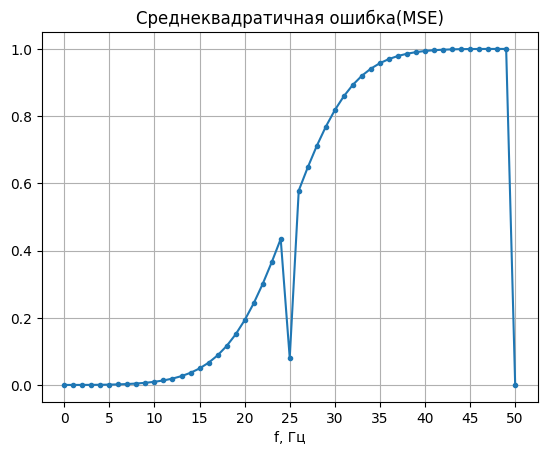

In [32]:
plt.plot(freq_list,mse_list, marker = '.')
plt.title('Среднеквадратичная ошибка(MSE)')
plt.xlabel('f, Гц')
plt.xticks(freq_list[::5])
plt.grid()
plt.show()

Ошибка минимальна на частотах ниже 10 Гц, после этого начинается рост ошибок из-за интерполяции и реализации дециматора через взятие отсчетов в 2 раза реже (фильтры отсутствуют, из-за этого теряются высокочастотные составляющие сигнала и ошибка сильно нарастает). 

Дойдя до 25 Гц (Вторая частота Найквиста при децимации 25 = 100/4) наблюдается провал, он обусловлен вырождением данного случая, т.к. после децимации отсчеты будут представлять из себя только минимумы и максимумы несущей, вот кубический сплайн и восстанавливает пропавшие значения примерно около нуля (см. ниже 'Графики вырожденных случаев').

После 25 Гц нарушается теорема Котельникова для децимированного сигнала, спектры отсчетов накладываются друг на друга -> наблюдаем алиазинг. Ошибка растет быстрее, получаем сигнал с частотой ниже в ~2-4 раза (хорошо видно на частоте 42 Гц, см. ниже 'Алиасинг')

На 50 Гц генератор перестает корректно работать из-за нарушения теоремы Котельникова для базового сигнала, соответственно и восстановление формы после интерполяции неверно, маленькая ошибка объясняется малыми амплитудами отсчетов (~1e-14), что в свою очередь вызвано некорректной работой генератора (см. ниже 'Графики вырожденных случаев').

## Графики вырожденных случаев

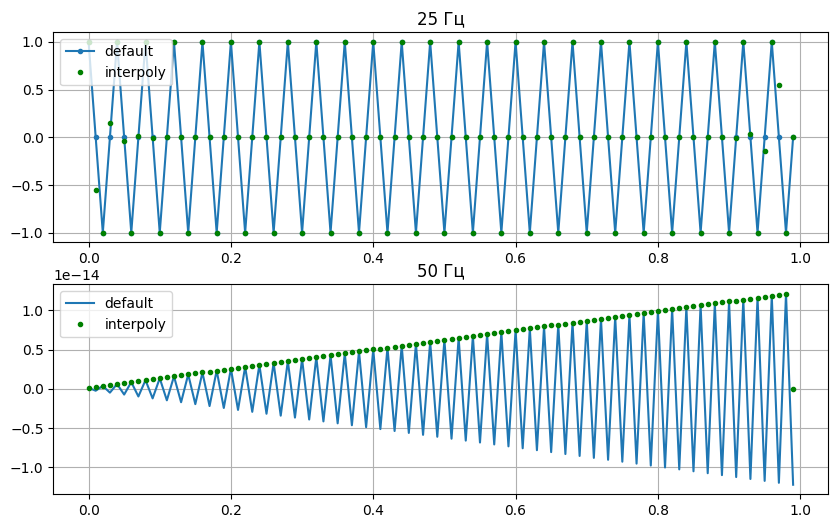

In [33]:
osc = Goertzel_sin_oscillator(freq=25, sample_rate=sample_rate)
osc2 = Goertzel_sin_oscillator(freq=50, sample_rate=sample_rate)
samples = [osc() for _ in range(n_samples)]
samples2 = [osc2() for _ in range(n_samples)]
samples_after_decim = Decim(samples)
samples_after_decim2 = Decim(samples2)
samples_after_interpoly = Cubic_spline_interpoly(time_axis2, samples_after_decim, time_axis)
samples_after_interpoly2 = Cubic_spline_interpoly(time_axis2, samples_after_decim2, time_axis)

# вторая частота Найквиста(25 Гц)
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(time_axis, samples, marker = '.' , label = 'default')
plt.plot(time_axis, samples_after_interpoly, '.',color = 'g', label = 'interpoly')
plt.title("25 Гц")
plt.legend()
plt.grid()

# Первая частота Найквиста(50 Гц)
plt.subplot(2,1,2)
plt.plot(time_axis, samples2, label = 'default')
plt.plot(time_axis, samples_after_interpoly2, '.',color = 'g', label = 'interpoly')
plt.title("50 Гц")
plt.legend()
plt.grid()
plt.show()


## Алиасинг

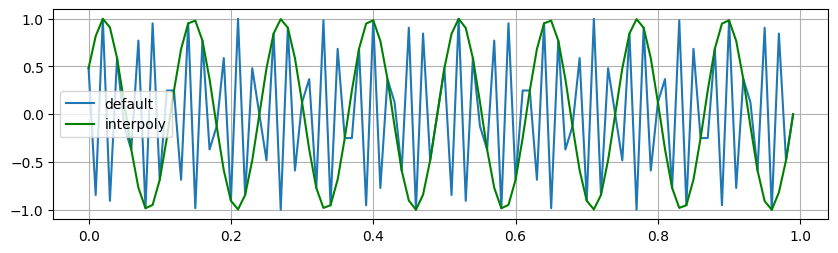

In [34]:
osc = Goertzel_sin_oscillator(freq=42, sample_rate=sample_rate)
samples = [osc() for _ in range(n_samples)]
samples_after_decim = Decim(samples)
samples_after_interpoly = Cubic_spline_interpoly(time_axis2, samples_after_decim, time_axis)

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(time_axis, samples , label = 'default')
plt.plot(time_axis, samples_after_interpoly, color = 'g', label = 'interpoly')
plt.legend()
plt.grid()